In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
from scipy.io import savemat

In [253]:
hdf5_file_path = ""
#df.to_hdf(hdf5_file_path, key='df', mode='w')

# Read the HDF5 file back into a DataFrame
df_loaded = pd.read_hdf(hdf5_file_path, key='df')

In [255]:
def calculate_capacity(current, time):
    n = len(time)
    
    # Check if the input arrays have the same length
    if n != len(current):
        raise ValueError("Input arrays must have the same length.")
    
    # Calculate the trapezoidal rule for the integral
    capacity = 0.5 * np.sum((np.array(current)[1:] + np.array(current)[:-1]) * (np.array(time)[1:] - np.array(time)[:-1]))
    return capacity

In [256]:
def calculate_soc(currentc, currentd,timec,timed,soc_previous,cap):
    delta_timec = np.diff(timec, prepend=0)
    delta_timed = np.diff(timed, prepend=0)
    soc_charge = soc_previous+(np.cumsum(currentc[1:] * delta_timec[1:]) / cap)
    soc_discharge = 1+(np.cumsum(currentd[1:] * delta_timed[1:]) / cap)
    soc=[]
    for i in range(len(soc_charge)):
        soc.append(soc_charge[i])
    for i in range(len(soc_discharge)):
        soc.append(soc_discharge[i])
    return soc


In [257]:
def is_constant_discharge(current_array, tolerance=0.01):
    # Set a tolerance level to account for small variations
    b=0
    for i in range(1, len(current_array)):
        # Check if the difference between consecutive values is within the tolerance
        if abs(current_array[i] - current_array[i-1]) > tolerance:
            b=b+1
    return (b<=3)

In [258]:
def calculate_soh(cap, datasheet_cap):
    return (cap/datasheet_cap)

In [266]:
def SOC_SOH_calculation_df(I,Time,datasheet_cap):
    if(len(np.where(np.diff(np.where(I[0]>0)[0])>1)[0])>0):
        s=np.where(np.diff(np.where(I[0]>0)[0])>1)[0][0]-1
    else: s=np.where(I[0]>0)[0][-1]
    currentc=I[0][0:s]
    currentd=I[0][s+1:]
    timec=Time[0][0:s]
    timed=Time[0][s+1:]
    Qc=calculate_capacity(currentc,timec)
    Qd=calculate_capacity(currentd,timed)
    soc_p=((-1)*Qd)-Qc
    cap=(-1)*Qd
    datasheet_cap=max(datasheet_cap,((-1)*Qd))
    soc=[]
    soh=[]
    for i in range(len(I)):
            if(len(np.where(np.diff(np.where(I[i]>0)[0])>1)[0])>0):
                s=np.where(np.diff(np.where(I[i]>0)[0])>1)[0][0]-1
            else: s=np.where(I[i]>0)[0][-1]
            currentc=I[i][0:s]
            currentd=I[i][s+1:]
            timec=Time[i][0:s]
            timed=Time[i][s+1:]
            Qd=calculate_capacity(currentd,timed)
            Qc=calculate_capacity(currentc,timec)
            soc.append(calculate_soc(currentc, currentd,timec,timed,soc_p,cap))
            soc_p=soc[i][-1]
            if(is_constant_discharge(currentd)):
                soh.append(calculate_soh(cap,datasheet_cap))
                cap=(-1)*Qd
            else: soh.append(calculate_soh(cap,datasheet_cap))
                
    return soc,soh 

In [262]:
SOC,SOH=SOC_SOH_calculation_df(df_loaded["I[A]"],df_loaded["Time[h]"],datasheet_cap=1.2)

1.3137977309248707 -1.198160431906096
-0.11563729901877484
1.198160431906096


Text(0, 0.5, 'SOH values')

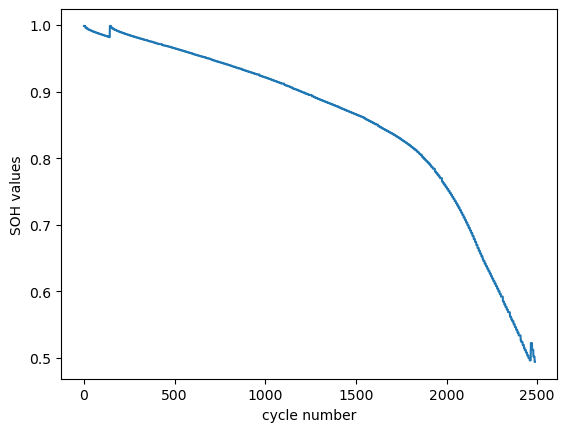

In [264]:
plt.plot(SOH)
plt.xlabel("cycle number")
plt.ylabel("SOH values")